<center>
  
# TABDDPM: Modelling Tabular Data with Diffusion Models

</center>

Directly applying diffusion models to general tabular problems can be challenging because data points are typically represented by vectors of heterogeneous features. The inherent heterogeneity of tabular data complicates accurate modeling, as individual features can vary widely in nature; some may be continuous, while others are discrete. In this notebook, we explore **TabDDPM** — a diffusion model that can be universally applied to tabular datasets and effectively handles both categorical and numerical features.

Our primary focus in this work is synthetic data generation, which is in high demand for many tabular tasks. Firstly, tabular datasets are often limited in size, unlike vision or NLP problems where large amounts of additional data are readily available online. Secondly, properly generated synthetic datasets do not contain actual user data, thus avoiding GDPR-like regulations and allowing for public sharing without compromising anonymity.

In the following sections, we will delve deeper into the implementation of this method. The notebook is organized as follows:

1. [Imports and Setup]()


2. [Default Dataset]()

    2.1. [Download Data]()
    
    2.2. [Process Data]()
    
    2.3. [Review Data]()
    
    
3. [TabDDPM Algorithm]()
    
    3.1. [Load Config]()
    
    3.2. [Make Dataset]()
    
    3.3. [Instantiate Model]()
    
    3.4. [Train Model]()
    
    3.5. [Load Pretrained Model]()
    
    3.6. [Sample Data]()
    
    3.7. [Review Synthetic Data]()

# Imports and Setup

In this section, we import all necessary libraries and modules required for setting up the environment. This includes basic libraries for such numpy and pandas. We also import essential modules for data loading, model creation, and dataset downloading and processing dataset. We also specify list of possible datasets and their download URL in `NAME_URL_DICT_UCI` where you can use each of these datasets for the rest of this notebook. Furthermore based on `DATA_DIR` we specify path to raw and processed data in `RAW_DATA_DIR` and `PROCESSED_DATA_DIR` to further download the data and process it in a desired format.  Here we will focus on `"adult"` dataset thus we will specify it in `DATA_NAME`. 

In [ ]:
import json
import os
from pprint import pprint

import numpy as np
import pandas as pd
import src
import torch
from scripts.download_dataset import download_from_uci
from scripts.process_dataset import process_data
from src.baselines.tabddpm.pipeline import TabDDPM
from src.data import make_dataset
from src.util import visualize_default


NAME_URL_DICT_UCI = {
    "adult": "https://archive.ics.uci.edu/static/public/2/adult.zip",
    "default": "https://archive.ics.uci.edu/static/public/350/default+of+credit+card+clients.zip",
    "magic": "https://archive.ics.uci.edu/static/public/159/magic+gamma+telescope.zip",
    "shoppers": "https://archive.ics.uci.edu/static/public/468/online+shoppers+purchasing+intention+dataset.zip",
    "beijing": "https://archive.ics.uci.edu/static/public/381/beijing+pm2+5+data.zip",
    "news": "https://archive.ics.uci.edu/static/public/332/online+news+popularity.zip",
}

# For shared directory you can change it to "/projects/diffusion_bootcamp/data/tabular"
DATA_DIR = "data"
RAW_DATA_DIR = f"{DATA_DIR}/raw_data"
PROCESSED_DATA_DIR = f"{DATA_DIR}/processed_data"
SYNTH_DATA_DIR = f"{DATA_DIR}/synthetic_data"
DATA_NAME = "default"

MODEL_PATH = "models/tabddpm"

# Default Dataset

In this section, we will download the **Default of Credit Card Clients** dataset from the UCI repository and load it into a pandas DataFrame. This dataset contains information on default payments, demographic factors, credit data, history of payment, and bill statements of credit card clients in Taiwan from April 2005 to September 2005. We will use this dataset to demonstrate the TabDDPM method.

## Download Data

We can download the required adult dataset to the specified directory in `RAW_DATA_DIR` using the download_from_uci function. This function takes the dataset name, the download path, and the URL of the data, and retrieves it from the UCI repository.

In [ ]:
download_from_uci(DATA_NAME, RAW_DATA_DIR, NAME_URL_DICT_UCI)

## Process Data

Now that we have downloaded the dataset, we need to process it into the desired CSV format using the `process_data` function. To do this, we provide the dataset name, the directory containing the information required for preprocessing, and the original data directory. The `INFO_DIR` contains a JSON file for each dataset, specifying the following:

1. task_type: This must be specified and can be binclass (binary classification) or regression, depending on the type of task for each dataset. For the adult dataset, the task type is binclass.
2. column_names: This is optional and contains the names of each column.
3. num_col_idx: This is necessary to specify the columns with numerical values.
4. cat_col_idx: This is necessary to specify the columns with categorical values.
5. target_col_idx: This is necessary to specify the column containing the target value for the regression or classification task.
6. file_type: This should be set to "csv" by default, as we want to preprocess the files as CSV.
7. data_path: Optional
8. test_path: Optional
9. column_info: Optional
10. train_num: Optional
11. test_num: Optional

The `process_data` function divides the raw data into training and test splits, saving them in `PROCESSED_DATA_DIR`. It also saves the processed information of the data as a JSON file in the same directory. Finally, it prints out general information about the training and test data after preprocessing, including:

1. Size of the training, validation, and test tables
2. Size of the numerical values in the training table
3. Size of the categorical values in the training table

In [ ]:
INFO_DIR = "data_info"
process_data(DATA_NAME, INFO_DIR, DATA_DIR)

## Review Data

After preprocessing, we will review the training dataset. To clarify the meaning of each categorical column value, we used the descriptions provided [here](https://www.kaggle.com/datasets/uciml/default-of-credit-card-clients-dataset). We implemented a `visualize_default` function that takes a DataFrame as input and replaces each category with its respective description.

In [ ]:
df = pd.read_csv(f"{PROCESSED_DATA_DIR}/{DATA_NAME}/train.csv")

# Display the first few rows of the DataFrame
visualize_default(df).head(10)

In [ ]:
# Open the JSON file and read its contents
with open(f"{PROCESSED_DATA_DIR}/{DATA_NAME}/info.json", "r") as file:
    data_info = json.load(file)

# Display the JSON data
# pprint(data_info)

# TabDDPM Algorithm

In this section, we will describe the design of TabDDPM as well as its main hyperparameters loaded through config, which affect the model’s effectiveness. 

**TabDDPM:** uses the multinomial diffusion to model the categorical and binary features, and the Gaussian diffusion to model the numerical ones. The model is trained using the diffusion process, which is a continuous-time Markov chain that models the data distribution. In more detail, for a tabular data sample that consists of N numerical featuresand C categorical features with Ki categories each, TabDDPM takes one-hot encoded versions of categorical features as an input, and normalized numerical features. The figure below illustrates the diffusion process for classification problems; t, y and l denote a diffusion timestep, a class label, and logits, respectively.

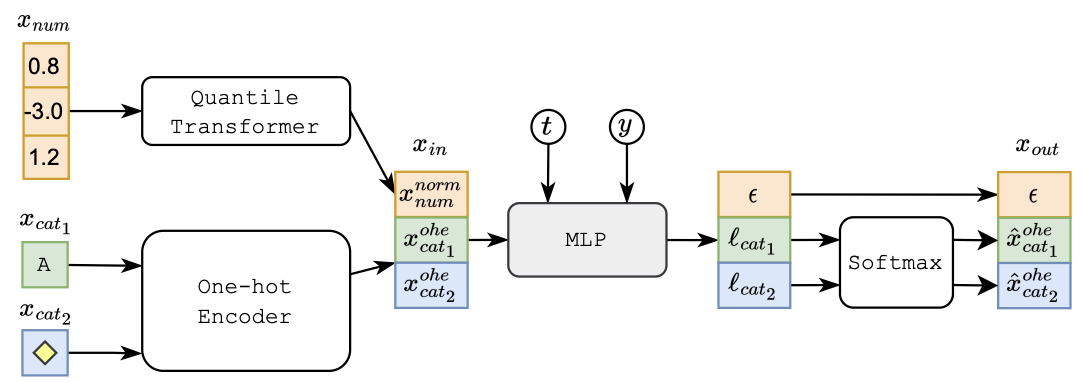

**Diffusion models:**  are likelihood-based generative models that handle the data through forward and reverse Markov processes. The forward process gradually adds noise to an initial sample x0 from the data distribution q(x0) sampling noise from the predefined distributions q(xt|xt−1) with variances {β1, ..., βT}.

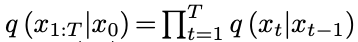

The reverse diffusion proces gradually denoises a latent variable xT∼q(xT) and allows generating new data samples from q(x0). Distributions p(xt−1|xt) are usually unknown and approximated by a neural network with parameters θ.

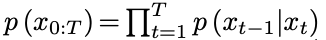

**Gaussian diffusion models:** operate in continuous spaces where forward and reverse processes are characterized by Gaussian distributions:

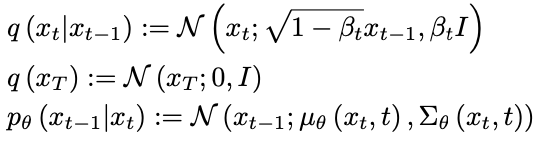

While in general θ parameters are learned from the data by optimizing a variational lower bound, in practice for Gaussian modeling, this objective can be simplified to the sum of mean-squared errors between εθ(xt ,t) and ε over all timesteps t as follows:

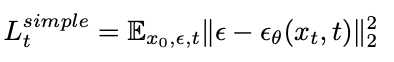

**Multinomial diffusion models:** are designed to generate categorical data where samples are a one-hot encoded categorical variable with K values. The multinomial forward diffusion process defines q(xt|xt−1) as a categorical distribution that corrupts the data by uniform noise over K classes: 

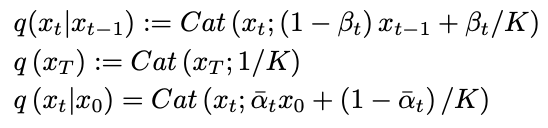

The reverse distribution pθ(xt−1|xt) is parameterized as q(xt−1|xt,xˆ0(xt,t)), where xˆ0 is predicted by a neural network. 

## Load Config

In this section, we will load the configuration file that contains the hyperparameters for the TabDDPM model. 

In [ ]:
config_path = f"src/baselines/tabddpm/configs/{DATA_NAME}.toml"
## Tabddpm is trained unconditional in this repo but conditional in main paper
raw_config = src.load_config(config_path)

pprint(raw_config)

The configuration file is a TOML file that contains the following hyperparameters:

1. **model_type:**  specifies the type of backbone model to be used for learning the denoising process. For Adult dataset, this should be set to "mlp". The reverse diffusion step in TabDDPM is modelled by a multi-layer neural network that has an output of the same dimensionality as x0, where the first N coordinates are the predictions of ε for the Gaussian diffusion and the rest are the predictions of x_ohe for the multinomial diffusions. This model takes as input the corrupted data xt and the timestep t, and outputs the denoised data xt−1 as follows:

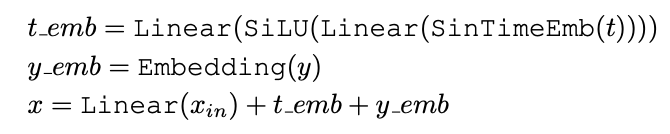

2. **model_params:** contains the hyperparameters for the backbone model. For the Adult dataset, we use an MLP model with the following hyperparameters:
    - is_y_cond: Whether the model is trained to be conditioned on the target value or not. By default, this should be set to True.
    - d_layers: The dimension of layers in the MLP model.
    - dropout: The dropout rate.


    
3. **task_type:** specifice the task type that we will use to conidition our training to and can be binclass (binary classification) or regression, depending on each dataset. For the Adult dataset, the task type is binclass. For classification datasets, we use a class- conditional model, i.e. pθ(xt−1|xt, y) is learned. For regression datasets, we consider a target value as an additional numerical feature, and the joint distribution is learned.

4. **diffusion_params:** contains number of total diffusion steps, the diffusion step size, and type of loss used to minimize the predicited noise in Gaussian diffusion. 

5. **train.main:** contains the basic hyperparameters for training the model such number of epochs (steps), the batch size (batch_size), the learning rate(lr), and the rate of weight decay (weight_decay).

6. **train.T:** contains the defined transformations on train data such as normalization, standardization, and one-hot encoding. 
    - For preprocessing numerical features, we use the gaussian quantile transformation and replace the Nan values with mean of each row. 
    - For categorical features, we use the one-hot encoding method. Each categorical feature is handled by a separate forward diffusion process, i.e., the noise components for all features are sampled independently. 

7. **sample:** contains the hyperparameters for sampling the data from the trained model. It includes the number of samples to generate, the batch size of sampling, and the seed used for random noise initialization.

8. **eval.T:** contains the defined transformations on evaluation data such as normalization, standardization, and one-hot encoding. 


## Make Dataset

Now that we have processed the data, we can create a dataset object. First we instantiate transformations needed for the dataset, such as normalization, standardization, and one-hot encoding in `T`. Next using make_dataset function we create a dataset object that contains the training and test data, as well as the column names, numerical column indices, and categorical column indices. This function takes the directory containing the processed data, the transformation and task type as input. Also it takes a boolean argument `change_val` that if it set true it will change the validation data to a split of train data rather than test data.
It returns a dataset object that contains the training and test data, as well as the column names, numerical column indices, and categorical column indices.

In [ ]:
T = src.Transformations(**raw_config["train"]["T"])

dataset = make_dataset(
    f"{PROCESSED_DATA_DIR}/{DATA_NAME}",
    T,
    task_type=raw_config["task_type"],
    change_val=False,
)

## Instantiate Model

Next, we instantiate the TabDDPM model. To do so first we need to apply some modifactions to loaded configs based on the dataset. We will set the number of numerical and size of one-hot coded categorical features based on the dataset.

In [ ]:
dim_categorical_features = np.array(dataset.get_category_sizes("train"))
print("Each Categorical Features Size: ", dim_categorical_features)
if (
    len(dim_categorical_features) == 0
    or raw_config["train"]["T"]["cat_encoding"] == "one-hot"
):
    dim_categorical_features = np.array([0])

num_numerical_features = (
    dataset.X_num["train"].shape[1] if dataset.X_num is not None else 0
)
print("Numerical Features Size: ", num_numerical_features)

We will also set the input size of the model as sum of size of categorical plus length of numerical features.

In [ ]:
dim_input = np.sum(dim_categorical_features) + num_numerical_features
raw_config["model_params"]["d_in"] = dim_input
print("Model Input Size:", dim_input)

Also we set device to be "cuda" if available otherwise we will use "cpu".

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

Finally, we will instantiate the model using the `TabDDPM` class. TabDDPM class takes the following arguments:

1. dataset: The dataset object containing the training and test data, as well as the column names, numerical column indices, and categorical column indices.
2. num_numerical_features: The number of numerical features in the dataset.
3. dim_categorical_features: The list of size of the one-hot encoded categorical features.
4. model_type: The type of backbone model to be used for learning the denoising process.
5. model_params: The hyperparameters for the backbone model.
6. diffusion_params: The hyperparameters for the diffusion process.
7. device: The device to use for training the model.

In [ ]:
tabddpm = TabDDPM(
    dataset=dataset,
    num_numerical_features=num_numerical_features,
    num_classes=dim_categorical_features,
    model_type=raw_config["model_type"],
    model_params=raw_config["model_params"],
    device=device,
    **raw_config["diffusion_params"],
)

TabDDPM class first instantiates the backbone model, which is a multi-layer neural network that models the reverse diffusion process using `get_model` function. It then passes this model to `GaussianMultinomialDiffusion` class to initializes the diffusion process.

## Train Model

Now that we have instantiated the model, we can train it using the `train` function. This function takes the training arguments from the config file and path to save the trained model. It trains the model on the training data using the `Trainer` class. It returns the trained model and the training loss.

In [ ]:
os.makedirs(f"{MODEL_PATH}/{DATA_NAME}")

tabddpm.train(
    **raw_config["train"]["main"],
    model_save_path=f"{MODEL_PATH}/{DATA_NAME}",
)

## Load pretrained Model

Instead of training model from scratch, we can also load weights of pre-trained model from give checkpoint with `load_model` function.

In [ ]:
pretrained_model_path = (
    "/projects/diffusion_bootcamp/models/tabular/tabddpm/default/model_100000.pt"
)

tabddpm.load_model(
    ckpt_path=pretrained_model_path,
)

## Sample Data

Now that we trained the model effectively, using `sample` function we can generate synthetic data starting from compelete noise. The input of this function is as follows:

1. info_path: The path to the JSON file containing the information about the dataset.
2. num_samples: The number of samples to generate.
3. batch_size: The batch size for sampling the data.
4. sample_save_path: The path to save the generated samples.
5. ddim: Whether the sampling strategy is DDPM (Denoising Diffusion Probabilistic Models) and DDIM (Denoising Diffusion Implicit Models). DDPM produces high-quality samples but requires many computationally expensive sampling steps, making it slower. In contrast, DDIM (Denoising Diffusion Implicit Models) offers faster sampling with fewer steps by using a deterministic process, maintaining similar sample quality with improved efficiency. The choice between them depends on the need for speed versus the highest possible sample quality.
6. steps: The number of steps for sampling the data. This is the number of diffusion steps to take when sampling the data. The higher the number of steps, the better the quality of the generated samples.


In [ ]:
tabddpm.sample(
    info_path=f"{PROCESSED_DATA_DIR}/{DATA_NAME}/info.json",
    num_samples=raw_config["sample"]["num_samples"],
    batch_size=raw_config["sample"]["batch_size"],
    sample_save_path=f"{SYNTH_DATA_DIR}/{DATA_NAME}/tabddpm.csv",
    ddim=True,
    steps=1000,
)

## Review Synthetic Data

Finally here, we review the synthesized data. In the following `evaluate_synthetic_data.ipynb` notebook, we will evaluate this synthesized data with respect to various metrics.

In [ ]:
df = pd.read_csv(f"{SYNTH_DATA_DIR}/{DATA_NAME}/tabddpm.csv")

# Display the first few rows of the DataFrame
visualize_default(df).head(10)

## References

**Kotelnikov, Akim, et al.** "TABDDPM: Modeling tabular data with diffusion models." *Advances in Neural Information Processing Systems* 36 (2021).

**GitHub Repository:** [Amazon Science - Tabsyn](https://github.com/amazon-science/tabsyn)